In [ ]:
#!/usr/bin/env python

__author__ = "Andrew D'Amico"
__copyright__ = "Copyright 2023"
__credits__ = ["Andrew D'Amico", "Christoper Alexander", "Katya Nosulko", "Vivek Chamala", "Matthew Conger"]
__license__ = ""
__version__ = "0.0.1"
__maintainer__ = "Andrew Damico"
__email__ = "andrew.damico@u.northwestern.edu"

In [1]:
!nvidia-smi

Thu Jun  1 01:01:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti      On | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P5               25W / 310W|    866MiB /  8192MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import os

###
import pandas as pd
#
import torch
import torchvision.transforms as transforms
###
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
###
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel, CLIPTextModel
# Callbacks
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, AutoTokenizer, CLIPFeatureExtractor
from transformers import default_data_collator
from transformers.integrations import TensorBoardCallback

### Custom
import helper
from clip_classes import CLIPTrainer

2023-06-02 00:06:35.768917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
writer = SummaryWriter()

# Dataset

In [20]:
folder = "/media/andrew/HD-GDU3/498/"
medical_reports = "cleaned_single_image_only_relevant_headings2.csv"
meta_data = "cleaned_single_image_only_relevant_headings_metadata.csv"
image_data = None
image_folder = None
dataset = "final_candidates_sentences.csv"
allsentences = "new_pairs_refined.csv"
md_location = folder + meta_data
meta_reports = pd.read_csv(md_location)
sample = meta_reports.head()

In [21]:
early_stop = EarlyStoppingCallback(
    early_stopping_patience=10.0,
    early_stopping_threshold=0
)
# ( early_stopping_patience: int = 1early_stopping_threshold: typing.Optional[float] = 0.0 ) 

# Model Parameters

In [22]:
#TEXT_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
#TEXT_MODEL = "clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/ClinicalBERT_1b/"
TEXT_MODEL = "clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/Pubmed_ClinicalBERT_1a/"
IMAGE_MODEL = 'openai/clip-vit-base-patch32'
FINETUNED_MODEL = 'radCLIP2_s2'
CLIP_MODEL = None
TEST_SIZE = 0.10
BATCH_SIZE = 16
GRADIENT_ACCUMULATION = 2
FP_16 = False
BASE_DIR = '/media/andrew/HD-GDU3/498/'

LEARNING_RATE = 3e-5  #3e-6
WEIGHT_DECAY = 0.01  #0.003, between 0 and .1
OPTIMIZER = "AdamW"
CALLBACKS = [TensorBoardCallback, early_stop]
IMAGE_SIZE = 224
MAX_LEN = 80
EPOCHS = 20
RUN_NAME = f'pubmed_{dataset}_{LEARNING_RATE}_{WEIGHT_DECAY}'
OUTPUT_DIR = BASE_DIR + RUN_NAME
MEAN = torch.tensor([0.42695613, 0.42695613, 0.42695613])  #Image Mean
STD = torch.tensor([0.31928246, 0.31928246, 0.31928246])  #Image STD

# Load Dataset

In [24]:
dataset = pd.read_csv(dataset)

In [26]:
def update_files(x):
    basename = os.path.basename(x)
    root = '/media/andrew/HD-GDU3/498/complete_imageset/'

    return (root + basename)

In [27]:
dataset['image'] = dataset['image'].apply(lambda x: update_files(x))
dataset = dataset.drop(columns='Unnamed: 0')

In [32]:
DATA_FILE = dataset

In [33]:
class CLIPDataset(Dataset):
    def __init__(self, image_paths: list, text: list, mode: str = 'train'):
        self.image_paths = image_paths
        self.tokens = tokenizer(text,
                                padding='max_length',
                                max_length=MAX_LEN,
                                truncation=True
                                )

        if mode == 'train':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                #transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])
        elif mode == 'test':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask,
                'pixel_values': self.augment(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        return len(self.image_paths)

In [34]:
df = dataset.dropna()
#test_df = pd.read_csv('test.csv').dropna()
#validate_df = pd.read_csv('validate.csv').dropna()
train_df, test_df = train_test_split(df, test_size=.1)
#
train_df, val_df = train_test_split(df, test_size=.2)
train_ds = CLIPDataset(image_paths=train_df.image.tolist(), text=train_df.caption.tolist(), mode='train')
test_ds = CLIPDataset(image_paths=val_df.image.tolist(), text=val_df.caption.tolist(), mode='test')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=default_data_collator)
test_df.to_csv('test_s2.csv')
train_df.to_csv('train_s2.csv')
val_df.to_csv('val_s2.csv')

# Build Model

In [29]:
vision_preprocessor = CLIPFeatureExtractor.from_pretrained(IMAGE_MODEL)

In [30]:
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [31]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    logging_steps=10,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=100,
    fp16=FP_16,
    prediction_loss_only=True,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,  #1
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    report_to='none',
    metric_for_best_model="loss",
    load_best_model_at_end=True
)

# Sample Image

In [35]:
def show_data(batch, idx=0):
    # show image
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)
    plt.imshow(img)
    # show text
    text = tokenizer.decode(batch['input_ids'][idx], skip_special_tokens=True)
    print('Text: ', text)

torch.Size([16, 80])
torch.Size([16, 3, 224, 224])
Image shape:  torch.Size([224, 224, 3])
Text:  et and ng tube are nominal in position.


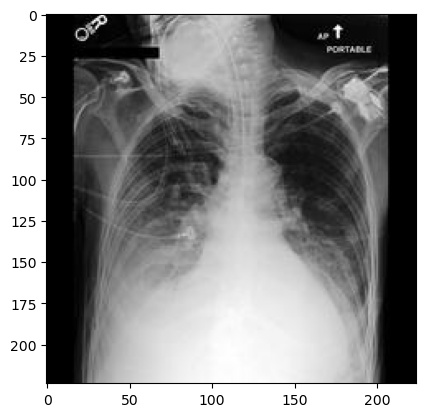

In [36]:
for item in train_dl:
    print(item['input_ids'].shape)
    print(item['pixel_values'].shape)
    break
show_data(item)

# Build Model Architecture

In [40]:
def clip_wrapper_creator():
    """create a dummy CLIPModel to wrap text and vision encoders in order to use CLIPTrainer"""
    config = {'num_hidden_layers': 0,
              'max_position_embeddings': 0,
              'vocab_size': 0,
              'hidden_size': 1,
              'patch_size': 1,
              }

    #DUMMY_CONFIG = CLIPConfig(text_config_dict=config,vision_config_dict=config)
    DUMMY_CONFIG = CLIPConfig(
        text_config_dict=config,
        vision_config_dict=config
    )

    clip = CLIPModel(config=DUMMY_CONFIG)

    # convert projectors to Identity
    clip.text_projection = nn.Identity()
    clip.visual_projection = nn.Identity()

    return clip

In [37]:
vision_encoder = CLIPVisionModel.from_pretrained(IMAGE_MODEL)
#config = CLIPConfig.from_pretrained("openai/clip-vit-base-patch16")
#vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16", config=config.vision_config)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.5.self_attn.q_proj.weight', 'text_model.encoder.layers.7.layer_norm2.bias', 'text_model.encoder.layers.10.layer_norm2.weight', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.1.self_attn.k_proj.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.7.mlp.fc1.bias', 'text_model.encoder.layers.8.layer_norm2.bias', 'text_model.encoder.layers.10.mlp.fc1.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.7.layer_norm1.weight', 'text_model.encoder.layers.5.mlp.fc1.bias', 'text_model.encoder.layers.4.mlp.fc1.weight', 'text_model.encoder.layers.4.mlp.fc2.weight', 'text_model.encoder.layers.5.layer_norm1.weight', 'text_model.encoder.layers.2.mlp.fc1.bias', 'text_model.encoder.layers.10.self_attn.q_proj.bias', 'text_model.encoder.layers.9.layer_norm1.weig

In [39]:
text_encoder = CLIPTextModel.from_pretrained(TEXT_MODEL)
#text_encoder = BertModel.from_pretrained("bert-base-uncased")

You are using a model of type bert to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing CLIPTextModel: ['bert.encoder.layer.7.output.LayerNorm.weight', 'bert.encoder.layer.11.output.dense.bias', 'bert.encoder.layer.6.attention.output.dense.weight', 'bert.encoder.layer.8.attention.self.value.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'bert.encoder.layer.3.output.dense.weight', 'bert.encoder.layer.1.output.dense.weight', 'bert.encoder.layer.10.intermediate.dense.bias', 'bert.encoder.layer.4.attention.self.query.weight', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.11.output.LayerNorm.bias', 'bert.encoder.layer.6.intermediate.dense.bias', 'cls.predictions.decoder.weight', 'bert.encoder.layer.6.attention.sel

In [41]:
#text_encoder = AutoModel.from_pretrained(TEXT_MODEL)
#text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')

clip = clip_wrapper_creator()
clip.text_model = text_encoder
clip.vision_model = vision_encoder

In [42]:
assert text_encoder.config.hidden_size == vision_encoder.config.hidden_size

## Train Model

In [43]:
def train_model():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    helper.clear_gpu()
    args.dataloader_num_workers = helper.optimal_workers()
    trainer = CLIPTrainer(clip, args,
                          train_dataset=train_ds,
                          eval_dataset=test_ds,
                          callbacks=CALLBACKS
                          )

    trainer.train()

In [44]:
activate_training = True

In [45]:
if activate_training:
    train_model()

if activate_training:
    clip.text_model.save_pretrained(FINETUNED_MODEL)
    tokenizer.save_pretrained(FINETUNED_MODEL)
    clip.vision_model.save_pretrained(FINETUNED_MODEL)
    vision_preprocessor.save_pretrained(FINETUNED_MODEL)
    clip.save_pretrained(FINETUNED_MODEL)

/home/andrew/miniconda3/envs/CLIP_demo/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 299817
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 187380
  Number of trainable parameters = 195174145


Step,Training Loss,Validation Loss
500,2.767600,2.767154
1000,2.738200,2.753224
1500,2.745500,2.741684
2000,2.739700,2.722472
2500,2.726000,2.720294
3000,2.675900,2.720863
3500,2.706400,2.708965
4000,2.660000,2.714595
4500,2.693800,2.701250
5000,2.651200,2.696572


***** Running Evaluation *****
  Num examples = 74955
  Batch size = 16
Saving model checkpoint to /media/andrew/HD-GDU3/498/pubmed_final_candidates_sentences.csv_3e-05_0.01/checkpoint-500
Configuration saved in /media/andrew/HD-GDU3/498/pubmed_final_candidates_sentences.csv_3e-05_0.01/checkpoint-500/config.json
Model weights saved in /media/andrew/HD-GDU3/498/pubmed_final_candidates_sentences.csv_3e-05_0.01/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 74955
  Batch size = 16
Saving model checkpoint to /media/andrew/HD-GDU3/498/pubmed_final_candidates_sentences.csv_3e-05_0.01/checkpoint-1000
Configuration saved in /media/andrew/HD-GDU3/498/pubmed_final_candidates_sentences.csv_3e-05_0.01/checkpoint-1000/config.json
Model weights saved in /media/andrew/HD-GDU3/498/pubmed_final_candidates_sentences.csv_3e-05_0.01/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 74955
  Batch size = 16
Saving model checkpoint to /media/a

# Evaluation and Demonstration

In [120]:
class VisionDataset(Dataset):
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

    def __init__(self, image_paths: list):
        self.image_paths = image_paths

    def __getitem__(self, idx):
        return self.preprocess(Image.open(self.image_paths[idx]).convert('RGB'))

    def __len__(self):
        return len(self.image_paths)


class TextDataset(Dataset):
    def __init__(self, text: list, tokenizer, max_len):
        self.len = len(text)
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=max_len, truncation=True)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask}

    def __len__(self):
        return self.len

In [3]:
FINETUNED_MODEL = 'radCLIP2'

In [121]:
vision_encoder = CLIPVisionModel.from_pretrained(FINETUNED_MODEL)
tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL)
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text_encoder = CLIPTextModel.from_pretrained(FINETUNED_MODEL)

You are using a model of type clip_vision_model to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at radCLIP2 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.8.self_attn.out_proj.bias', 'vision_model.encoder.layers.3.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.6.layer_norm1.bias', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.9.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.10.mlp.fc1.bias', 'vision

In [228]:
import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import default_data_collator


class CLIPDemo:
    def __init__(self, vision_encoder, text_encoder, tokenizer,
                 batch_size: int = 32, max_len: int = MAX_LEN, device='cuda'):
        """ Initializes CLIPDemo
            it has the following functionalities:
                image_search: Search images based on text query
                zero_shot: Zero shot image classification
                analogy: Analogies with embedding space arithmetic.

            Args:
            vision_encoder: Fine-tuned vision encoder
            text_encoder: Fine-tuned text encoder
            tokenizer: Transformers tokenizer
            device (torch.device): Running device
            batch_size (int): Size of mini-batches used to embeddings
            max_length (int): Tokenizer max length

            Example:
            >>> demo = CLIPDemo(vision_encoder, text_encoder, tokenizer)
            >>> demo.compute_image_embeddings(test_df.image.to_list())
            >>> demo.image_search('یک مرد و یک زن')
            >>> demo.zero_shot('./workers.jpg')
            >>> demo.anology('./sunset.jpg', additional_text='دریا')
        """
        self.vision_encoder = vision_encoder.eval().to(device)
        self.text_encoder = text_encoder.eval().to(device)
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = 70  #MAX_LEN
        self.text_embeddings_ = None
        self.image_embeddings_ = None

    def compute_image_embeddings(self, image_paths: list):
        self.image_paths = image_paths
        datalodear = DataLoader(VisionDataset(
            image_paths=image_paths), batch_size=self.batch_size)
        embeddings = []
        with torch.no_grad():
            for images in tqdm(datalodear, desc='computing image embeddings'):
                image_embedding = self.vision_encoder(
                    pixel_values=images.to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.image_embeddings_ = torch.cat(embeddings)

    def compute_text_embeddings(self, text: list):
        self.text = text
        dataloader = DataLoader(TextDataset(text=text, tokenizer=self.tokenizer, max_len=self.max_len),
                                batch_size=self.batch_size, collate_fn=default_data_collator)
        embeddings = []
        with torch.no_grad():
            for tokens in tqdm(dataloader, desc='computing text embeddings'):
                image_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                                    attention_mask=tokens["attention_mask"].to(
                                                        self.device)).pooler_output
                embeddings.append(image_embedding)
        self.text_embeddings_ = torch.cat(embeddings)

    def text_query_embedding(self, query: str = ''):
        tokens = self.tokenizer(query, return_tensors='pt')
        with torch.no_grad():
            text_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                               attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
        return text_embedding

    def image_query_embedding(self, image):
        image = VisionDataset.preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_embedding = self.vision_encoder(
                image.to(self.device)).pooler_output
        return image_embedding

    def most_similars(self, embeddings_1, embeddings_2):
        values, indices = torch.cosine_similarity(
            embeddings_1, embeddings_2).sort(descending=True)
        return values.cpu(), indices.cpu()

    def zero_shot(self, image_path: str):
        """ Zero shot image classification with label list 
            Args:
                image_path (str): target image path that is going to be classified
                class_list (list[str]): list of candidate classes 
        """
        image = Image.open(image_path)
        image_embedding = self.image_query_embedding(image)
        values, indices = self.most_similars(image_embedding, self.text_embeddings_)
        printout = []
        for i, sim in zip(indices, torch.softmax(values, dim=0)):
            print(f'label: {self.text[i]} | {round(float(sim), 10)}')
        plt.imshow(image)
        plt.axis('off')

    def image_search(self, query: str, top_k=25):
        """ Search images based on text query
            Args:
                query (str): text query 
                image_paths (list[str]): a bunch of image paths
                top_k (int): number of relevant images 
        """
        query_embedding = self.text_query_embedding(query=query)
        _, indices = self.most_similars(self.image_embeddings_, query_embedding)

        matches = np.array(self.image_paths)[indices][:top_k]
        _, axes = plt.subplots(2, int(top_k / 2), figsize=(15, 5))
        for match, ax in zip(matches, axes.flatten()):
            ax.imshow(Image.open(match).resize((224, 224)))
            ax.axis("off")
        plt.show()

    def analogy(self, input_image_path: str, additional_text: str = '', input_include=True):
        """ Analogies with embedding space arithmetic.
            Args:
                input_image_path (str): The path to original image 
                image_paths (list[str]): A database of images
        """
        base_image = Image.open(input_image_path)
        image_embedding = self.image_query_embedding(base_image)
        additional_embedding = self.text_query_embedding(query=additional_text)
        new_image_embedding = image_embedding + additional_embedding
        _, indices = self.most_similars(
            self.image_embeddings_, new_image_embedding)

        new_image = Image.open(self.image_paths[indices[1 if input_include else 0]])
        _, ax = plt.subplots(1, 2, dpi=100)
        ax[0].imshow(base_image.resize((250, 250)))
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(new_image.resize((250, 250)))
        ax[1].set_title('new image')
        ax[1].axis('off')

In [229]:
def image_text_comp(id, MAXSENT=100):
    search.zero_shot(f'{Demo_image_dataset["image"][id]}')
    print("")
    print(Demo_image_dataset['caption'][id])

In [230]:
Demo_image_dataset = test_df

In [231]:
search = CLIPDemo(vision_encoder, text_encoder, tokenizer)

In [232]:
search.compute_image_embeddings(Demo_image_dataset.image.to_list())

computing image embeddings: 100%|█████████████████████████████████████████████████████████| 473/473 [00:29<00:00, 16.28it/s]


In [233]:
single_terms = [
    'lungs fully expanded',
    'heart size enlarged',
    'pacemaker',
    'device',
    'pneumothorax',
    "pulmonary edema",
    "mild pulmonary edema",
    'endotracheal tube',
    'port-a-cath',
    "collapsed",
    'endotracheal tube',
    'bibasilar atelectasis'
]

In [234]:
sentence_terms = [
    'moderate cardiomegaly is increased since , perhaps a function of lower lung volumes. mild to moderate pulmonary edema and small bilateral pleural effusions are stable. no pneumothorax. infusion port catheter ends in the right atrium and atrioventricular pacer leads continuous from the left pectoral pacemaker are all unchanged.',
    'comparison with the study dated at p.m., there has been minimal interval change. the patient is status post left pleurx catheter removal. redemonstrated are bilateral pleural effusions, slightly more prominent on the left. the left pacemaker and right port-a-cath are essentially unchanged. there is no evidence of acute pneumonia or vascular congestion',
    'there is no evidence of pneumothorax. the left pectoral pacemaker and right port-a-cath are in unchanged position. no pleural effusions. slightly lower lung volumes than on location of the previous radiograph. minimal atelectasis at the right lung basis. unchanged normal appearance of the cardiac silhouette',
    'there are two pigtail catheters within the right chest. there is again seen a small right-sided pleural effusion with some loculation along the right lateral chest wall. this appears unchanged. there are no pneumothoraces. there is a left-sided pacemaker. slight blunting of the left cp angle is again seen and unchanged. there are no signs for overt pulmonary edema or focal consolidation.'
]

In [235]:
from nltk.tokenize import sent_tokenize

In [236]:
Demo_image_dataset

,caption,image
7410,no evidence of pneumothorax status post bronch...,/media/andrew/HD-GDU3/498/complete_imageset/19...
50178,grossly unchanged appearance of bilateral pleu...,/media/andrew/HD-GDU3/498/complete_imageset/13...
71423,previous improvement seen earlier today in bil...,/media/andrew/HD-GDU3/498/complete_imageset/10...
73843,no good evidence of a pneumonia. some congesti...,/media/andrew/HD-GDU3/498/complete_imageset/10...
19725,"in comparison with the study of , there again ...",/media/andrew/HD-GDU3/498/complete_imageset/17...
...,...,...
61416,no focal infiltrate. . there are low lung volu...,/media/andrew/HD-GDU3/498/complete_imageset/11...
37573,in comparison to prior radiograph from earlier...,/media/andrew/HD-GDU3/498/complete_imageset/15...
39386,left chest tube has been removed. there is no ...,/media/andrew/HD-GDU3/498/complete_imageset/14...
51833,heart size and mediastinum are stable. right c...,/media/andrew/HD-GDU3/498/complete_imageset/13...


In [248]:
sentences = []
for par in Demo_image_dataset['caption'].dropna().unique():
    sentences += sent_tokenize(par)
sentences = [*set(sentences)]

In [285]:
reports = []
reports = Demo_image_dataset['caption'].to_list()
reports = [*set(reports)]

In [287]:
def compute_text_embeddings_experiment(corpus='word'):
    if corpus == 'word':
        search.compute_text_embeddings(single_terms)
    elif corpus == 'sentences':
        search.compute_text_embeddings(sentence_terms)
    elif corpus == 'all_sentences':
        search.compute_text_embeddings(sentences)
    elif corpus == 'all_reports':
        search.compute_text_embeddings(reports)
    else:
        print(f'Corpus not found. Manually run compute_text_embeddings script!')

In [288]:
compute_text_embeddings_experiment('all_reports')

computing text embeddings: 100%|██████████████████████████████████████████████████████████| 470/470 [00:20<00:00, 23.20it/s]


## Search for images

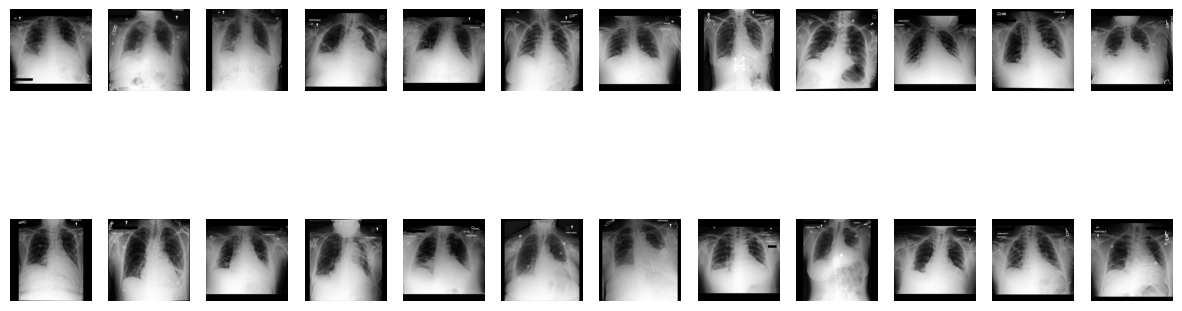

In [252]:
search.image_search('pneumothorax')  #make sure to use a term in the test set!

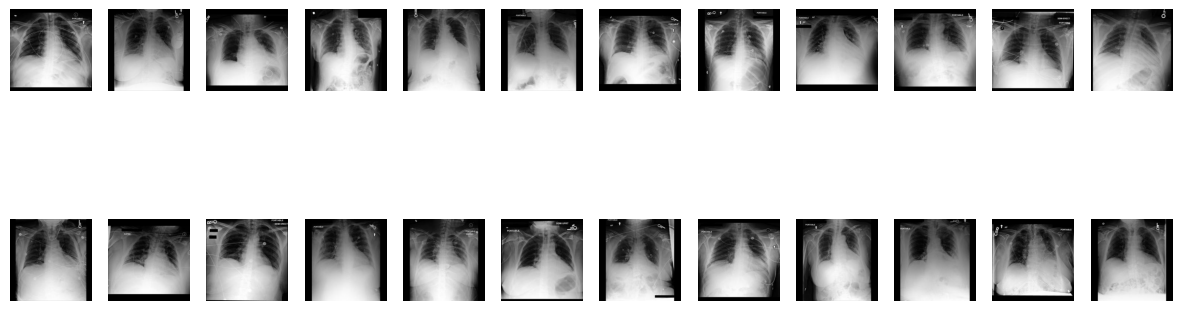

In [253]:
search.image_search('no pneumothorax')

In [254]:
Demo_image_dataset.head(10)

,caption,image
7410,no evidence of pneumothorax status post bronch...,/media/andrew/HD-GDU3/498/complete_imageset/19...
50178,grossly unchanged appearance of bilateral pleu...,/media/andrew/HD-GDU3/498/complete_imageset/13...
71423,previous improvement seen earlier today in bil...,/media/andrew/HD-GDU3/498/complete_imageset/10...
73843,no good evidence of a pneumonia. some congesti...,/media/andrew/HD-GDU3/498/complete_imageset/10...
19725,"in comparison with the study of , there again ...",/media/andrew/HD-GDU3/498/complete_imageset/17...
10740,normal size of the cardiac silhouette. no pleu...,/media/andrew/HD-GDU3/498/complete_imageset/18...
54377,no acute cardiopulmonary process. prior pleura...,/media/andrew/HD-GDU3/498/complete_imageset/12...
74468,"in comparison with chest radiograph, a right s...",/media/andrew/HD-GDU3/498/complete_imageset/10...
25149,no acute cardiac or pulmonary process. there i...,/media/andrew/HD-GDU3/498/complete_imageset/16...
44173,swan-ganz catheter tip is at the level of the ...,/media/andrew/HD-GDU3/498/complete_imageset/14...


In [255]:
Demo_image_dataset['caption'][7410]

'no evidence of pneumothorax status post bronchoscopic biopsy of large right upper lobe mass. a large right upper lung opacity is not significantly changed in size compared to the outside hospital chest radiograph from , corresponding to a cm right upper lobe mass on recent ct from . the lungs are otherwise clear. the heart size is normal. the mediastinal contours are normal. there is no pneumothorax. no pleural effusions. '

## Find all documents with a term. 
This is used to get the row number to use below

In [270]:
substring = 'pacemaker'
substr = Demo_image_dataset[
    Demo_image_dataset.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
substr

,caption,image
73843,no good evidence of a pneumonia. some congesti...,/media/andrew/HD-GDU3/498/complete_imageset/10...
44173,swan-ganz catheter tip is at the level of the ...,/media/andrew/HD-GDU3/498/complete_imageset/14...
18379,there is a new lead pacemaker with leads proje...,/media/andrew/HD-GDU3/498/complete_imageset/17...
48387,no evidence for pneumonia or pulmonary edema. ...,/media/andrew/HD-GDU3/498/complete_imageset/13...
68228,severe left pleural effusion has significantly...,/media/andrew/HD-GDU3/498/complete_imageset/11...
...,...,...
63687,swan-ganz catheter terminating within a right ...,/media/andrew/HD-GDU3/498/complete_imageset/11...
30898,left-sided dual lead pacemaker is unchanged. t...,/media/andrew/HD-GDU3/498/complete_imageset/15...
28900,comparison is made to previous study from . th...,/media/andrew/HD-GDU3/498/complete_imageset/16...
70076,areas of bilateral atelectasis are seen. in th...,/media/andrew/HD-GDU3/498/complete_imageset/10...


In [271]:
for row in substr.head(10).index:
    print(f'{row}: {substr.caption[row]}')
    print('')

    #print (df.head()['caption'])

73843: no good evidence of a pneumonia. some congestive changes suggested although some of this may reflect the technique there is massive cardiomegaly present. pacemaker is in unchanged position. no significant effusion. ct localization peribronchial cuffing is noted consistent with some congestive change. no good evidence of pneumonia. 

44173: swan-ganz catheter tip is at the level of the right main pulmonary artery. a right internal jugular line tip is at the level of mid svc. pacemaker defibrillator lead terminates in the right ventricle. left ventricular assist device is in place. patient continues to be in pulmonary edema with no distinct consolidation to suggest infectious process. tracheostomy is in place. 

18379: there is a new lead pacemaker with leads projecting over the expected location. there continues to be mild cardiomegaly and mild pulmonary vascular redistribution. there increased interstitial markings in the left upper lung as well as volume loss in the lower lungs

# Get closest text embeddings for an image
Uses the embeddings calculated above

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



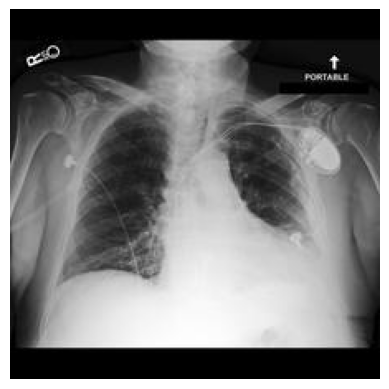

In [293]:
image_text_comp(66881)  #Need to change to only show top sentences

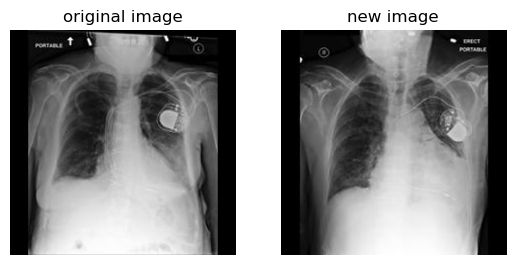

In [62]:
search.analogy(f'{Demo_image_dataset["image"][51]}')